In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../")
from dataloader.svdd_dataloader import CollisionLoader_new
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from load_data import load_data
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
import librosa
%matplotlib inline

In [3]:
train_imu,train_audio,train_spec,val_imu,val_audio,val_spec,val_imu_normal,val_audio_normal,val_spec_normal,total_list = load_data()

train_combine = np.concatenate([np.mean(train_audio,axis=-1),train_imu],axis=1)

test_audio_all = np.concatenate([val_audio_normal,val_audio],axis=0)
test_imu_all   = np.concatenate([val_imu_normal,val_imu],axis=0)
test_combine = np.concatenate([np.mean(test_audio_all,axis=-1),test_imu_all],axis=1)

labels_all = np.concatenate([np.zeros(val_audio_normal.shape[0]),np.ones(val_audio.shape[0])])

In [4]:
clf_audio = IsolationForest(contamination=0.1, random_state=42).fit(np.mean(train_audio,axis=-1))
clf_imu = IsolationForest(contamination=0.1, random_state=42).fit(train_imu)
clf_all = IsolationForest(contamination=0.1, random_state=42).fit(train_combine)


In [5]:
scores_audio      = 1-clf_audio.decision_function(np.mean(test_audio_all,axis=-1))
scores_imu        = 1-clf_imu.decision_function(test_imu_all)
scores_all        = 1-clf_all.decision_function(test_combine)

eval_metrics_audio = ts_metrics(labels_all, scores_audio)
eval_metrics_imu = ts_metrics(labels_all, scores_imu+scores_audio)
result_audio = eval_metrics_audio
result_imu = eval_metrics_imu
eval_metrics_all = ts_metrics(labels_all, scores_all)
result_all = eval_metrics_all

print(result_audio[:-2])
print(result_imu[:-2])
print(result_all[:-2])

# np.save("IF_p",result_imu[-2])
# np.save("IF_r",result_imu[-1])

(0.9060682898059542, 0.8681574335858941, 0.8108741904346652, 0.8124207858048162, 0.8093434343434344)
(0.7476419208532695, 0.7047584657059012, 0.6840646299616048, 0.7279202279202279, 0.6452020202020202)
(0.8918055970893141, 0.8512419143218266, 0.7846404178496786, 0.8093959731543624, 0.7613636363636364)


In [6]:
from sklearn import metrics
precision, recall, thresholds= metrics.precision_recall_curve(labels_all, (scores_audio))
epsilon = 1e-10

f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(best_threshold)
indoor_group = []
outdoor_group = []
mach_group = []
coli_group = []
for idx, filepath in enumerate(total_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    if sequence=='seq16':
        file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['iseq2', 'iseq5'] or (sequence == 'seq16' and  file_number >= 104):
        indoor_group.append(idx)  # Add the index of the file
    elif sequence in ['seq15', 'seq10'] or (sequence == 'seq16' and  file_number < 104):
        outdoor_group.append(idx)  # Add the index of the file
    elif sequence in ['bl', 'br','fl','fr']:
        mach_group.append(idx)  # Add the index of the file
    else:
        coli_group.append(idx)  # Add the index of the file

indoor_losses = [scores_audio[idx] for idx in indoor_group]
outdoor_losses = [scores_audio[idx] for idx in outdoor_group]
mach_losses = [scores_audio[idx] for idx in mach_group]
coli_losses = [scores_audio[idx] for idx in coli_group]

0.9342567756452231


In [7]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_indoor = [0] * len(indoor_losses)  # All indoor samples are normal
true_labels_outdoor = [0] * len(outdoor_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = indoor_losses + outdoor_losses
all_true_labels = true_labels_indoor + true_labels_outdoor

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_indoor = sum(predicted_labels[i] == true_labels_indoor[i] for i in range(len(indoor_losses))) / len(indoor_losses) if len(indoor_losses) > 0 else 0
accuracy_outdoor = sum(predicted_labels[len(indoor_losses) + i] == true_labels_outdoor[i] for i in range(len(outdoor_losses))) / len(outdoor_losses) if len(outdoor_losses) > 0 else 0

print("\nIndoor Group Accuracy:")
print(f"  Accuracy: {accuracy_indoor:.4f}")

print("\nOutdoor Group Accuracy:")
print(f"  Accuracy: {accuracy_outdoor:.4f}")


Overall Accuracy:
  Accuracy: 0.8783

Indoor Group Accuracy:
  Accuracy: 0.8458

Outdoor Group Accuracy:
  Accuracy: 0.9146


In [8]:
true_labels_mach = [1] * len(mach_losses)  # All indoor samples are normal
true_labels_coli = [1] * len(coli_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = mach_losses + coli_losses
all_true_labels = true_labels_mach + true_labels_coli

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_mach = sum(predicted_labels[i] == true_labels_mach[i] for i in range(len(mach_losses))) / len(mach_losses) if len(mach_losses) > 0 else 0
accuracy_coli = sum(predicted_labels[len(mach_losses) + i] == true_labels_coli[i] for i in range(len(coli_losses))) / len(coli_losses) if len(outdoor_losses) > 0 else 0

print("\nmach Group Accuracy:")
print(f"  Accuracy: {accuracy_mach:.4f}")

print("\ncoli Group Accuracy:")
print(f"  Accuracy: {accuracy_coli:.4f}")

Overall Accuracy:
  Accuracy: 0.8081

mach Group Accuracy:
  Accuracy: 0.9669

coli Group Accuracy:
  Accuracy: 0.5161


Text(0.5, 1.0, 'Reconstruction Loss Distribution')

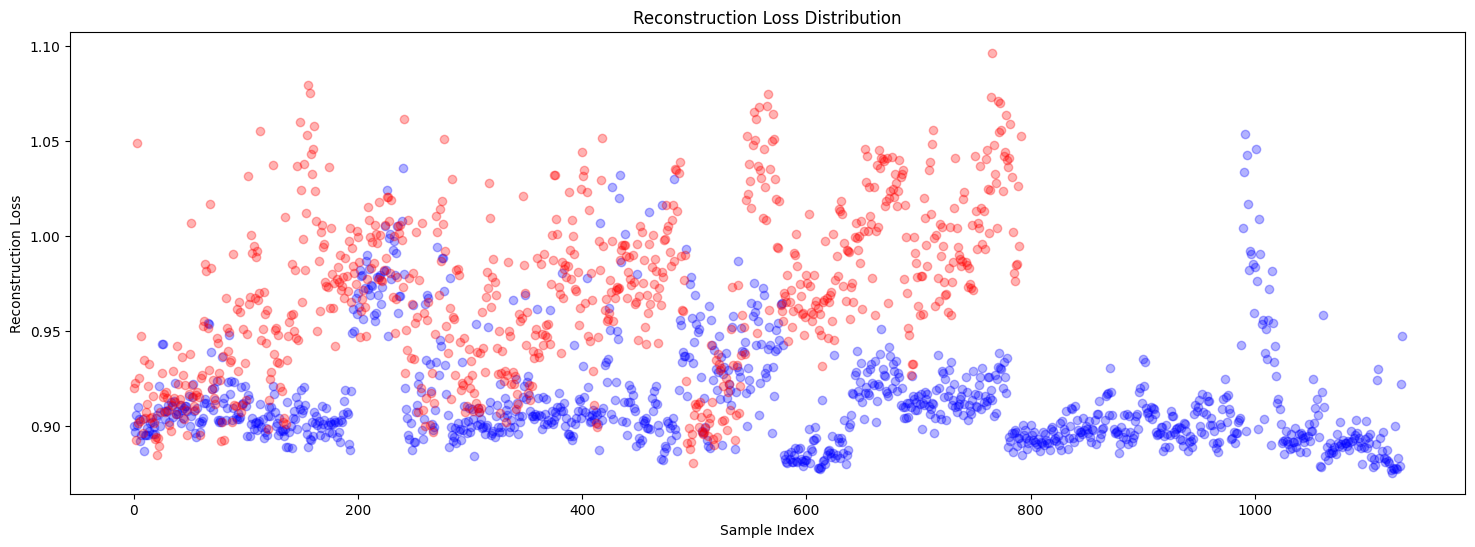

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))

plt.scatter(range(len(val_audio_normal)), scores_audio[:len(val_audio_normal)], color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(val_audio)), scores_audio[len(val_audio_normal):], color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(-0.2,0.2)

In [9]:
distance_audio_normal = if_audio.decision_function(np.mean(val_audio_normal, axis=-1))
distance_imu_normal = if_imu.decision_function(val_imu_normal)

distance_audio = if_audio.decision_function(np.mean(val_audio, axis=-1))
distance_imu = if_imu.decision_function(val_imu)

# Calculate the mean of the decision function scores for normal data
mean_distance_audio = np.mean(distance_audio_normal)
mean_distance_imu = np.mean(distance_imu_normal)

# Classify the data based on the mean decision scores
distance_audio = np.where(distance_audio >= mean_distance_audio, 1, 0)
distance_imu = np.where(distance_imu >= mean_distance_imu, 1, 0)

# Calculate False Negatives (FN) and True Negatives (TN)
FN = np.sum(distance_audio * distance_imu != 0)
TN = np.sum(distance_audio * distance_imu == 0)

# Classify the normal data based on the mean decision scores
distance_audio_normal = np.where(distance_audio_normal >= mean_distance_audio, 1, 0)
distance_imu_normal = np.where(distance_imu_normal >= mean_distance_imu, 1, 0)

# Calculate True Positives (TP) and False Positives (FP)
TP = np.sum(distance_audio_normal * distance_imu_normal != 0)
FP = np.sum(distance_audio_normal * distance_imu_normal == 0)

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Negatives (TN):", TN)

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
if (precision + recall) != 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

True Positives (TP): 662
False Positives (FP): 554
False Negatives (FN): 51
True Negatives (TN): 711
Accuracy: 0.6941354903943378
Precision: 0.5444078947368421
Recall: 0.9284712482468443
F1 Score: 0.6863659927423535
